1. load trained model of interest (fixed input shape, no global pooling, nomask, all features used for training)
   it can not be the best resmico, some layers are not supported by shap
2. select datapath and stats file
3. 200 random short contigs for background
4. 100 pos and 100 neg contigs to explain

shap explanations take about 30min 

In [1]:
import sys
import os
sys.path.insert(1, '/cluster/home/omineeva/ResMiCo')
from resmico import contig_reader
from resmico import utils
from resmico import models_fl as Models
from tensorflow.keras.models import load_model
from resmico.commands.evaluate import parse_args

2022-01-20 16:30:38.593776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import random

In [3]:
project_path = '/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/'
save_path = project_path + 'Outputs/predictions/'

In [6]:
# model_name = project_path + 'Outputs/mc_epoch_32_aucPR_0.643_max624-111-d02-fl16-nblo4_model.h5'
model_name = project_path + 'Outputs/mc_epoch_32_aucPR_0.683_fimp2_model.h5'

In [7]:
custom_obj = {'class_recall_0': utils.class_recall_0, 'class_recall_1': utils.class_recall_1,
              'GlobalMaskedMaxPooling1D': Models.GlobalMaskedMaxPooling1D}


model = load_model(model_name, custom_objects=custom_obj)

2022-01-20 16:31:40.710758: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-20 16:31:40.720175: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-20 16:31:40.738763: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-20 16:31:40.738793: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: le-g3-007
2022-01-20 16:31:40.738799: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: le-g3-007
2022-01-20 16:31:40.738883: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.80.2
2022-01-20 16:31:40.738909: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.80.2
2022-01-20 16:31:40.738914: I tensorflow/stream_executor/cu

In [8]:
data_path = project_path + \
            'data/v2/resmico-sm/GTDBr202_n9k_novel-family_test/features/' 

# stats_file = project_path + \
#             '/data/v2/resmico-sm/GTDBr202_n9k_train/features/' + \
#             'stats.json'

stats_file = project_path + \
            '/data/v2/resmico-sm/GTDBr202_n9k_train_1rep/stats_cov.json'

In [9]:
joint_line = ''

joint_line += ' --features'
features_imp =" ref_base num_query_A num_query_C num_query_G num_query_T coverage num_proper_Match num_orphans_Match max_insert_size_Match mean_insert_size_Match min_insert_size_Match stdev_insert_size_Match mean_mapq_Match min_mapq_Match stdev_mapq_Match mean_al_score_Match min_al_score_Match stdev_al_score_Match num_proper_SNP"
features_imp2=" ref_base num_query_A num_query_C num_query_G num_query_T coverage max_insert_size_Match mean_insert_size_Match min_insert_size_Match stdev_insert_size_Match max_mapq_Match mean_mapq_Match min_mapq_Match stdev_mapq_Match max_al_score_Match mean_al_score_Match min_al_score_Match stdev_al_score_Match num_SNPs num_proper_SNP num_proper_Match num_discordant num_orphans_Match "
joint_line += features_imp2

joint_line += ' --feature-files-path '
joint_line += data_path

joint_line += ' --stats-file '
joint_line += stats_file

joint_line += ' --max-len=5000 '


joint_line += ' --binary-data '

In [10]:
args = parse_args().parse_args(joint_line.split())

In [11]:
args

Namespace(model='/cluster/home/omineeva/ResMiCo/resmico/model/fl_all_model.h5', batch_size=100, sdepth=None, rich=None, filter10=False, rep10=False, method_pred='chunks', min_len=1000, mem_lim=500000, window=5000, v1=False, longdir=False, embeddings=False, emb_ind=0, binary_data=True, gpu_eval_mem_gb=3.0, val_ind_f=None, chunks=False, log_level='INFO', no_cython=False, seed=12, n_procs=1, max_len=5000, save_path='.', save_name='resmico', feature_files_path='/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/data/v2/resmico-sm/GTDBr202_n9k_novel-family_test/features/', feature_file_table='', technology='all-asmbl', big_data=False, features=['ref_base', 'num_query_A', 'num_query_C', 'num_query_G', 'num_query_T', 'coverage', 'max_insert_size_Match', 'mean_insert_size_Match', 'min_insert_size_Match', 'stdev_insert_size_Match', 'max_mapq_Match', 'mean_mapq_Match', 'min_mapq_Match', 'stdev_mapq_Match', 'max_al_score_Match', 'mean_al_score_Match', 'min_al_score_Match'

In [12]:
if args.mask_padding:
    convoluted_size = Models.get_convoluted_size(model)
else:  # when not padding, the convoluted size is unused
    convoluted_size = lambda len, pad: 0

In [13]:
reader = contig_reader.ContigReader(args.feature_files_path, args.features, args.n_procs, args.chunks,
                                    args.no_cython, args.stats_file, args.min_len)

In [14]:
#use only short contigs for simplicity
eval_idx = []
for ind, contig in enumerate(reader.contigs):
    if contig.length < 5000:
        eval_idx.append(ind)

In [15]:
back_idx = np.random.choice(eval_idx, 200, replace=False)

In [16]:
pos_idx = []
for idx in random.sample(eval_idx, len(eval_idx)):
    if reader.contigs[idx].misassembly > 0:
        if idx not in set(back_idx):
            pos_idx.append(idx)

In [17]:
neg_idx = []
c=0
for idx in random.sample(eval_idx, len(eval_idx)):
    if reader.contigs[idx].misassembly == 0:
        if idx not in set(back_idx):
            neg_idx.append(idx)
            c+=1
            if c>100:
                break

In [18]:
expl_idx = np.concatenate((pos_idx[:100],neg_idx[:100]))

In [19]:
set(expl_idx).intersection(set(back_idx))

set()

In [20]:
# for i in expl_idx:
#     print(i, reader.contigs[i].breakpoints, reader.contigs[i].misassembly, reader.contigs[i].length)

In [21]:
back_data = Models.BinaryDatasetEval(reader, back_idx, args.features, args.max_len, max(250, args.max_len-500),
                                        int(args.gpu_eval_mem_gb * 1e9 * 0.8), cache_results=False,
                                        show_progress=False, convoluted_size=convoluted_size, pad_to_max_len=True)

In [22]:
(x_back, mask), y = back_data.__getitem__(0)

In [23]:
len(x_back)

200

In [24]:
expl_data = Models.BinaryDatasetEval(reader, expl_idx, args.features, args.max_len, max(250, args.max_len-500),
                                        int(args.gpu_eval_mem_gb * 1e9 * 0.8), cache_results=False,
                                        show_progress=False, convoluted_size=convoluted_size, pad_to_max_len=True)

In [25]:
(x_expl, mask), y = expl_data.__getitem__(0)

In [26]:
len(x_expl)

200

In [27]:
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), x_back)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [28]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

In [29]:
shap_values = e.shap_values(x_expl)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2022-01-20 16:32:46.560086: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-20 16:32:46.570578: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2249950000 Hz


In [30]:
features = features_imp2.split(' ')[1:]
features = np.concatenate(([features[0]]*3, features))

In [31]:
plt.rcParams["figure.figsize"] = [5, 5]
arr = np.zeros(26)
for n, cont in enumerate(expl_idx):
    for i in range(reader.contigs[cont].length): 
        arr+=abs(shap_values[0][n][i])
arr=arr/n 
inds = arr.argsort()

In [32]:
features[inds]

array(['ref_base', 'ref_base', 'ref_base', 'ref_base', 'num_discordant',
       'num_proper_SNP', 'max_mapq_Match', 'stdev_mapq_Match',
       'stdev_insert_size_Match', 'min_mapq_Match', 'num_proper_Match',
       'num_orphans_Match', 'num_query_G', 'num_query_C', 'num_query_A',
       'max_al_score_Match', 'num_query_T', 'stdev_al_score_Match',
       'mean_insert_size_Match', 'max_insert_size_Match',
       'min_insert_size_Match', 'mean_mapq_Match', 'num_SNPs', 'coverage',
       'min_al_score_Match', 'mean_al_score_Match'], dtype='<U23')

In [33]:
inds_oneref = list(inds)
inds_oneref.remove(0)
inds_oneref.remove(1)
inds_oneref.remove(2)
inds_oneref

[3,
 24,
 22,
 13,
 16,
 12,
 15,
 23,
 25,
 6,
 5,
 4,
 17,
 7,
 20,
 10,
 9,
 11,
 14,
 21,
 8,
 19,
 18]

In [34]:
savefig_path=project_path+'Outputs/figures'

In [ ]:
#todo: change feature names

Text(0.5, 0, 'mean(|SHAP value|)')

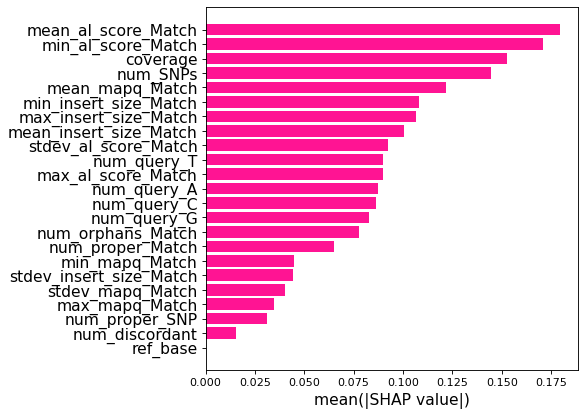

In [35]:
plt.figure(figsize=(6, 6), dpi=80)
y_pos = np.arange(23)
plt.yticks(y_pos, labels=features[inds_oneref], fontsize=14)
plt.barh(y_pos, arr[inds_oneref], color='deeppink')
plt.xlabel('mean(|SHAP value|)', fontsize=14)

# where = os.path.join(savefig_path,'shap.pdf')
# plt.savefig(where, 
#             bbox_inches='tight', format='pdf', dpi=300)
# print(where)
# plt.show()

In [36]:
{k:v for k, v in zip(features, arr)}

{'ref_base': 0.0003485153646749759,
 'num_query_A': 0.08721410507900959,
 'num_query_C': 0.08645045342955279,
 'num_query_G': 0.08274602203990356,
 'num_query_T': 0.08979263740790056,
 'coverage': 0.1525170557965516,
 'max_insert_size_Match': 0.10673509174307608,
 'mean_insert_size_Match': 0.10047644247632047,
 'min_insert_size_Match': 0.10809871009095133,
 'stdev_insert_size_Match': 0.044027574904123366,
 'max_mapq_Match': 0.03454637295222416,
 'mean_mapq_Match': 0.12169421846251291,
 'min_mapq_Match': 0.04477217435382488,
 'stdev_mapq_Match': 0.0402769059317806,
 'max_al_score_Match': 0.08976540899699398,
 'mean_al_score_Match': 0.17942266483325284,
 'min_al_score_Match': 0.1709269581646705,
 'stdev_al_score_Match': 0.09245847550786496,
 'num_SNPs': 0.1444732931943834,
 'num_proper_SNP': 0.031144925780767746,
 'num_proper_Match': 0.06487877275582281,
 'num_discordant': 0.015567381855719268,
 'num_orphans_Match': 0.07781893660864456}